# 10. Linear Regression

This chapter will introduce you to linear regression analysis in R. We will cover how to fit linear regression models, check model assumptions using diagnostic plots, change model formulas by adding transformations and interactions, calculate performance metrics, and perform variable selection using stepwise selection. 

For this chapter, we will use the `NHANESsample` dataset, which was retrieved from the National Health and Nutrition Examination Survey ([NHANES](https://www.cdc.gov/nchs/nhanes/index.htm)) and is in the `HDSinRdata` package. The sample contains lead, blood pressure, BMI, smoking status, alcohol use, and demographic variables from NHANES 1999-2018. Variable selection and feature engineering were conducted in an effort to replicate the regression analyses conducted by [Huang, Z. (2022). Association Between Blood Lead Level With High Blood Pressure in US (NHANES 1999-2018). Frontiers in Public Health, 892](https://www.frontiersin.org/articles/10.3389/fpubh.2022.836357/full). Use the help operator `?NHANESsample` to read the variable descriptions. Note that we ignore survey weights for this analysis. 

We will use the `broom` package to present the estimated coefficients for our regression models and the `car` package to compute variance inflation factors.

In [1]:
suppressPackageStartupMessages(library(HDSinRdata))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(broom))
suppressPackageStartupMessages(library(car))
data(NHANESsample)

## Simple Linear Regression

In [Chapter 4](https://alicepaul.github.io/health-data-science-in-r/book/4_exploratory_analysis.html), we presented some initial exploratory analysis for this data. In this chapter, we will use linear regression to understand the association between blood lead levels and systolic blood pressure, adjusting for possible confounders. Replicating the analysis of [Huang](https://www.frontiersin.org/articles/10.3389/fpubh.2022.836357/full), we create summary columns for systolic and diastolic blood pressure. If an observation has one blood pressure reading, then we use that value. If there is more than one blood pressure reading, then we drop the first observation and average the rest. We do a complete case analysis by dropping any observation with NA values. This leaves us with 30,405 observations. 

In [2]:
NHANESsample$SBP <- apply(NHANESsample[,c("SBP1", "SBP2", "SBP3", "SBP4")], 1, 
    function(x) case_when(sum(!is.na(x)) == 0 ~ NA, 
                          sum(!is.na(x)) == 1 ~ sum(x, na.rm=TRUE),
                          sum(!is.na(x)) > 1 ~ mean(x[-1], na.rm=TRUE))) 
NHANESsample$DBP <- apply(NHANESsample[,c("DBP1", "DBP2", "DBP3", "DBP4")], 1, 
    function(x) case_when(sum(!is.na(x)) == 0 ~ NA, 
                          sum(!is.na(x)) == 1 ~ sum(x, na.rm=TRUE),
                          sum(!is.na(x)) > 1 ~ mean(x[-1], na.rm=TRUE))) 
nhanes_df <- na.omit(subset(NHANESsample, select= -c(SBP1, SBP2, SBP3, SBP4, 
                                                     DBP1, DBP2, DBP3, DBP4)))
dim(nhanes_df)

[1] 30405    15

Next, we make sure any categorical variables are coded as factors.

In [3]:
nhanes_df$SEX <- as.factor(nhanes_df$SEX)
nhanes_df$RACE <- as.factor(nhanes_df$RACE)
nhanes_df$EDUCATION <- as.factor(nhanes_df$EDUCATION)
nhanes_df$BMI_CAT <- as.factor(nhanes_df$BMI_CAT)
nhanes_df$LEAD_QUANTILE <- as.factor(nhanes_df$LEAD_QUANTILE)

We will start with simple linear regression. Below, we plot the relationship between blood lead level and systolic blood pressure. For a simple linear regression scenario with a single continuous independent variable, a scatter plot allows us to easily visualize whether we meet the assumptions underlying linear regression. The survey sampling for the NHANES survey allows us to assume that each observation is independent. Looking at the plots below, we expect to see that the average systolic blood pressure increases linearly with blood lead level and that the observations look normally distributed with equal variance along that line. Below, we do not observe that to be the case. We will come back to this in the section on transformations and interactions. 

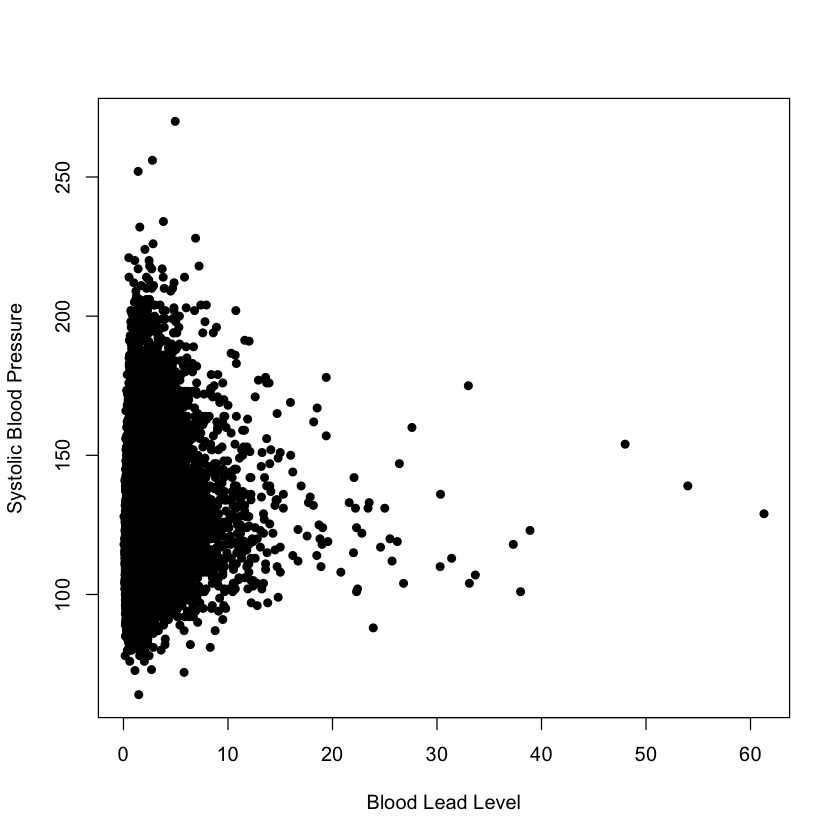

In [4]:
plot(nhanes_df$LEAD, nhanes_df$SBP,
     xlab = "Blood Lead Level", ylab = "Systolic Blood Pressure", pch=16)

Despite our observations above, we will continue by fiting a simple linear regression model to explain the association between `SBP` and `LEAD`. The function `lm(formula = y ~ x, data)` fits a linear model in R. The first argument is the formula of the linear model: on the left hand side of the `~` we put the outcome variable, and on the right hand side we put the independent variable. When we have multiple indepedent variables we separate them with a `+` (e.g. `y~x1+x2`). The output of this function is an `lm` object. 

We can call the `summary()` function on this object to print a summary of the model, which includes the estimated coefficients, information about the residuals, the R-squared and adjusted R-squared values, and the F-statistic. Recall, that we previously used the `summary()` function to get summary statistics about a vector. This is an example of how multiple functions can have the same name. R figues out which `summary()` function to use by identifying that the argument we passed in is a `lm` object. 

In [5]:
simp_model <- lm(formula = SBP~LEAD, data = nhanes_df)
summary(simp_model)


Call:
lm(formula = SBP ~ LEAD, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-96.360 -12.519  -2.791   9.363 140.880 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 120.66481    0.14950  807.11   <2e-16 ***
LEAD          1.70820    0.05802   29.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.47 on 30403 degrees of freedom
Multiple R-squared:  0.02772,	Adjusted R-squared:  0.02769 
F-statistic: 866.8 on 1 and 30403 DF,  p-value: < 2.2e-16


To visualize this model, we can add the estimated regression line to our scatter plot from above. In `ggplot2`, this can be done with the `geom_smooth()` function. In base R, we use the `abline()` function, which can take in a regression model as an input. We can see that the estimated regression line does not fit our data very well.

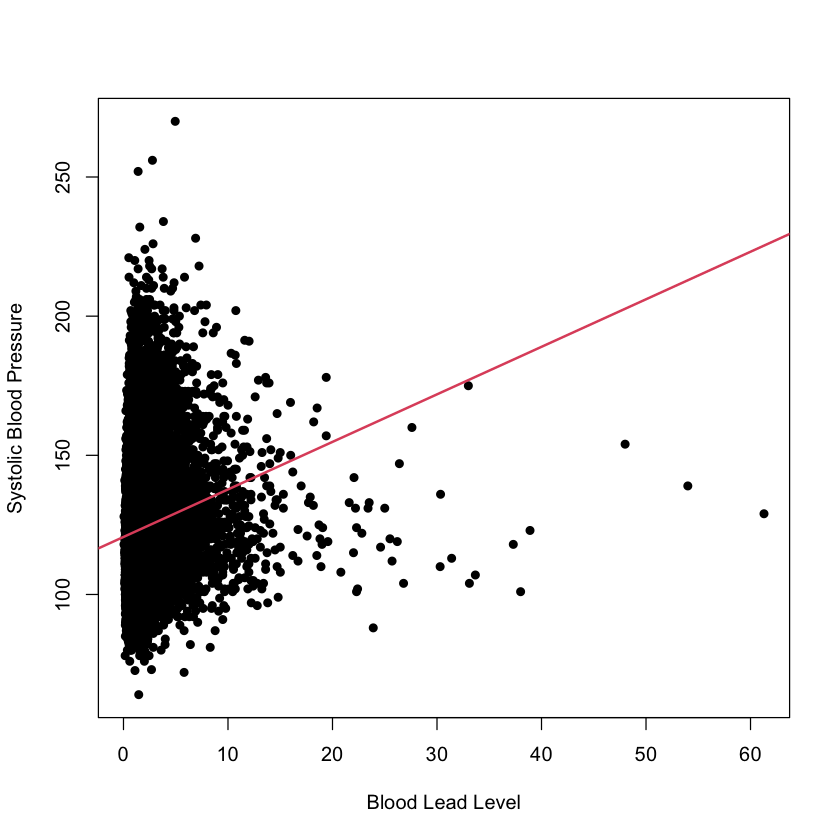

In [6]:
plot(nhanes_df$LEAD, nhanes_df$SBP, 
     ylab=c("Systolic Blood Pressure"),
     xlab=c("Blood Lead Level"), pch=16)
abline(simp_model, col=2, lwd=2)

### Practice Question

Fit a simple linear regression model with `SBP` as the outcome and `AGE` as the independent variable. The estimated coefficient for `AGE` should be 0.47693. Then, plot these two variables against each other and add the estimated regression line to the plot, as we did above. You should see that this regression has a better fit than the previous one. 

In [7]:
# Insert your solution here:

## Multiple Linear Regression

We now create a model that is similar to the previous one except that it also adjusts for age and sex. To add these variables into the model, we have to specify a new formula. Below, we fit this model and then print a summary, again using the `summary()` function.

In [8]:
adj_model <- lm(SBP ~ LEAD + AGE + SEX, data = nhanes_df)
summary(adj_model)


Call:
lm(formula = SBP ~ LEAD + AGE + SEX, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-65.623 -10.592  -1.551   8.547 131.595 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 101.785406   0.303532 335.337  < 2e-16 ***
LEAD          0.400071   0.055246   7.242 4.54e-13 ***
AGE           0.461932   0.005567  82.971  < 2e-16 ***
SEXFemale    -2.777737   0.195674 -14.196  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.64 on 30401 degrees of freedom
Multiple R-squared:  0.2116,	Adjusted R-squared:  0.2115 
F-statistic:  2720 on 3 and 30401 DF,  p-value: < 2.2e-16


We can also extract the estimated regression coefficients from the model using the `coef()` function or by using the `tidy` function from the `broom` package. This function puts the coefficient estimates, standard errors, statistics, and p-values in a data frame. We can also add a confidence interval by specifying `conf.int = TRUE`. Below, we add a 95% confidence interval (which is the default value for `conf.level`). 

In [9]:
coef(adj_model)

(Intercept)        LEAD         AGE   SEXFemale 
101.7854062   0.4000715   0.4619320  -2.7777367

In [10]:
tidy(adj_model, conf.int=TRUE, conf.level=0.95)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),101.7854062,0.303531788,335.33689,0.000000e+00,101.1904712,102.3803413
LEAD,0.4000715,0.055246352,7.24159,4.539720e-13,0.2917863,0.5083566
AGE,0.4619320,0.005567391,82.97099,0.000000e+00,0.4510196,0.4728443
SEXFemale,-2.7777367,0.195674149,-14.19573,1.362265e-45,-3.1612662,-2.3942071


Some other useful summary functions are `resid()`, which returns the residual values for the model, and `fitted()`, which returns the fitted values or estimated y values. We can also predict on new data using the `predict()` function. Below we look at the distribution of the residual values and then plot the fitted vs. true values. We observe some extreme residual values as well as the fact that the absolute residual values increase with increased blood pressure values. 

In [11]:
summary(resid(adj_model))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-65.624 -10.592  -1.551   0.000   8.547 131.595 

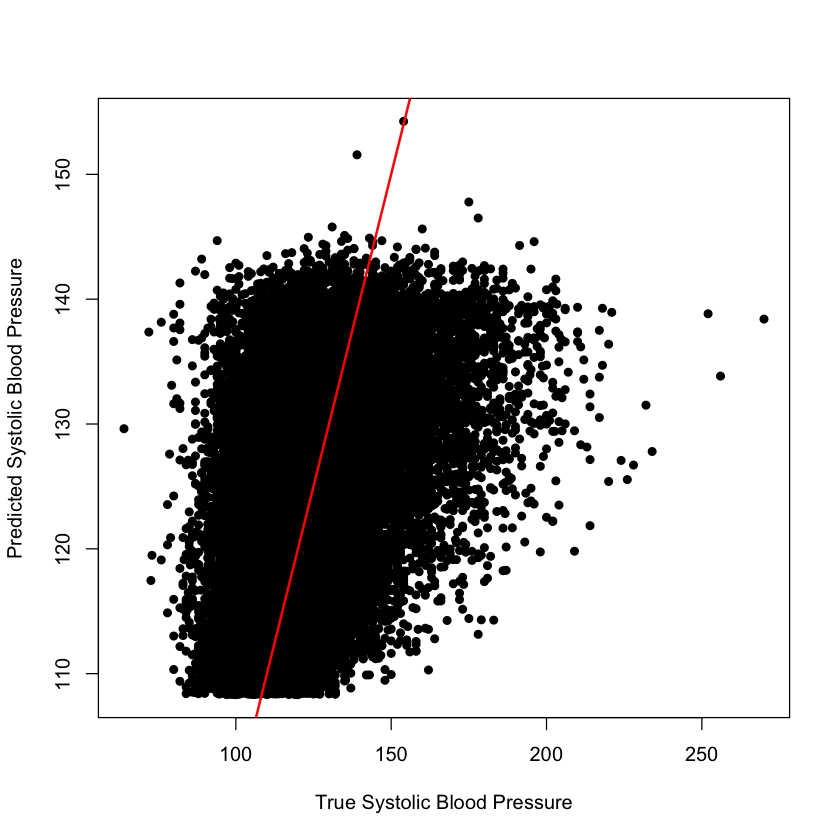

In [12]:
plot(nhanes_df$SBP, fitted(adj_model), 
     xlab ="True Systolic Blood Pressure", 
     ylab="Predicted Systolic Blood Pressure", pch=16)
abline(a=0, b=1, col="red", lwd=2)

We can next perform a nested hypothesis test between our simple linear regresion model and our adjusted model using the `anova()` function. We pass both models to this function along with the argument `test="F"` to indicate that we are performing an F-test. The `print()` function shows the two tested models along with the associated p-value, which indicates a significantly better fit for the adjusted model.

In [13]:
print(anova(simp_model, adj_model, test="F"))

Analysis of Variance Table

Model 1: SBP ~ LEAD
Model 2: SBP ~ LEAD + AGE + SEX
  Res.Df      RSS Df Sum of Sq      F    Pr(>F)    
1  30403 10375769                                  
2  30401  8413303  2   1962467 3545.6 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The model summary for the adjusted model displays the estimated coefficient for `sex` as `SEXFemale`, which indicates that the reference level for sex is male. If we want to change our reference level, we can reorder the factor variable either by using the `factor()` function and specifying `Female` as the first level or by using the `relevel()` function. The `ref` argument in the `relevel()` function specifies the new reference level. Now, when we run the model, we can see that the estimated coefficient for `sex` is labeled as `SEXMale`. 

In [14]:
nhanes_df$SEX <- relevel(nhanes_df$SEX, ref="Female")
adj_model2 <- lm(SBP ~ LEAD + AGE + SEX, data = nhanes_df)
tidy(adj_model2)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),99.0076695,0.292867408,338.06312,0.000000e+00
LEAD,0.4000715,0.055246352,7.24159,4.539720e-13
AGE,0.4619320,0.005567391,82.97099,0.000000e+00
SEXMale,2.7777367,0.195674149,14.19573,1.362265e-45


The formula passed to the `lm()` function also allows us to use the `.` to indicate that we would like to include all remaining columns as independent variables or the `-` to exclude variables. Below, we show how we could use these to fit a model with `LEAD`, `AGE`, and `SEX` as included covariates by excluding all other variables instead of by specifying these three variables themselves. 

In [15]:
lm(SBP ~ . - ID - RACE - EDUCATION - INCOME - SMOKE - YEAR - BMI_CAT - 
   LEAD_QUANTILE - DBP - ALC - HYP - RACE, data = nhanes_df)


Call:
lm(formula = SBP ~ . - ID - RACE - EDUCATION - INCOME - SMOKE - 
    YEAR - BMI_CAT - LEAD_QUANTILE - DBP - ALC - HYP - RACE, 
    data = nhanes_df)

Coefficients:
(Intercept)          AGE      SEXMale         LEAD  
    99.0077       0.4619       2.7777       0.4001  


## Diagnostic Plots and Measures

We can tell from the above plot that our model doesn't have a great fit. We will use some further diagnostic plots and measures to learn more. R has some built-in plots available for linear regression models, which can be displayed using the `plot()` function. Similar the `summary()` function, this function acts differently when passed an `lm` object. The four plots include (a) Residuals vs. Fitted, (b) a QQ-plot for the residuals, (c) Standardized residuals (sqrt) vs. Fitted, and (d) Standardized Residuals vs. Leverage. In the last plot, you may observe that there is a dashed line. Any points outside of these lines have a Cook’s distance of greater than 0.5. Additionally, points with labels correspond to the points with the largest residuals, so this last plot summarizes the outliers, leverage, and influential points. The plots below show that our residuals do not look normally distributed and that we have may have some high leverage points.

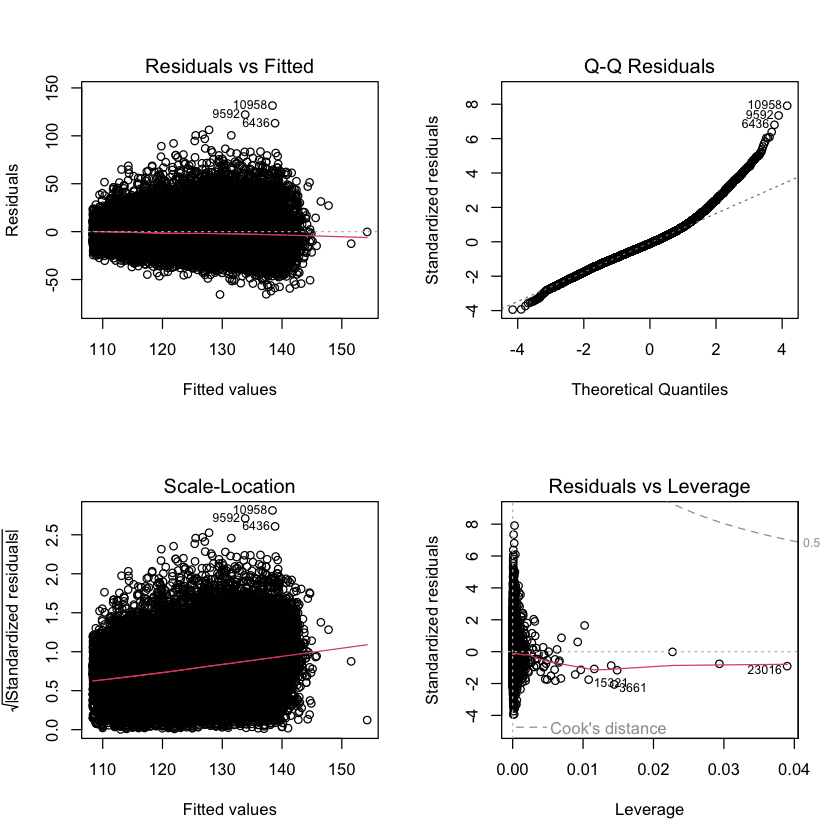

In [16]:
par(mfrow=c(2,2)) # plots all four plots together
plot(adj_model)

### Normality

Beyond the default plots, we can also plot a histogram of the residuals and a qq-plot. The `qqnorm()` and `qqline()` functions can take in the residuals from our model as an argument. The latter adds the theoretical red line for reference. As both the histogram and qq-plot shown, the residuals are positively skewed, and thus the assumption of normality is not satisfied for our residuals. Later in this chapter, we will discuss how we might transform this dataset and/or model to satisfy this assumption. 

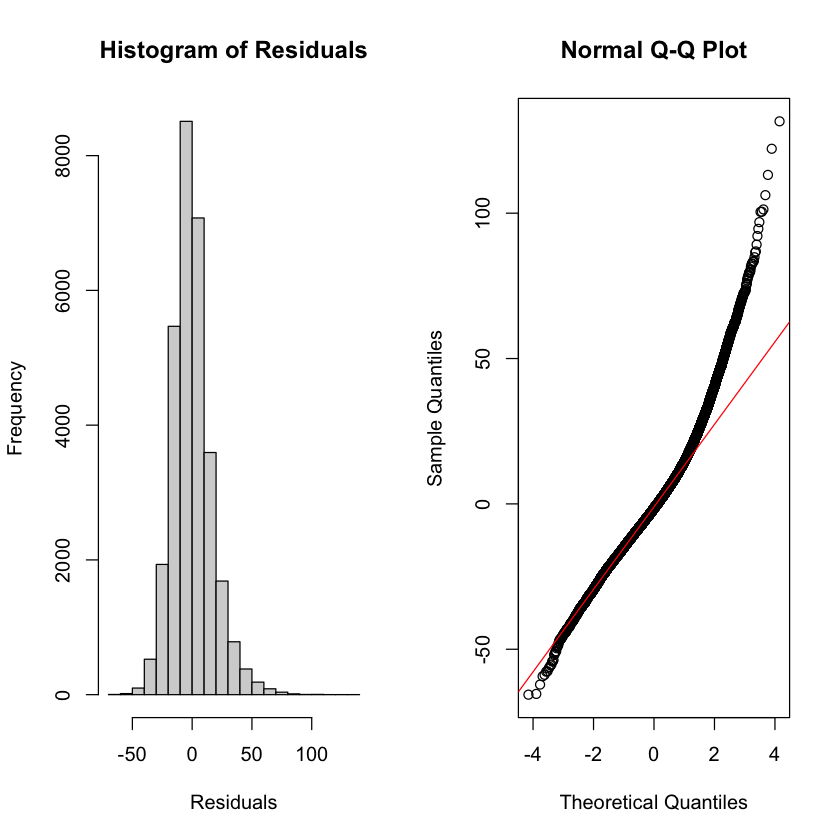

In [17]:
par(mfrow=c(1,2)) # plot next to each other
hist(resid(adj_model), xlab="Residuals", main="Histogram of Residuals") 
qqnorm(resid(adj_model))
qqline(resid(adj_model),col="red") 

Instead of using the direct residuals, we can create the plots above using the standardized residuals with the function `rstandard()`. The standardized residuals are the raw residuals divided by an estimate of the standard deviation for the residual, which will be different for each observation.

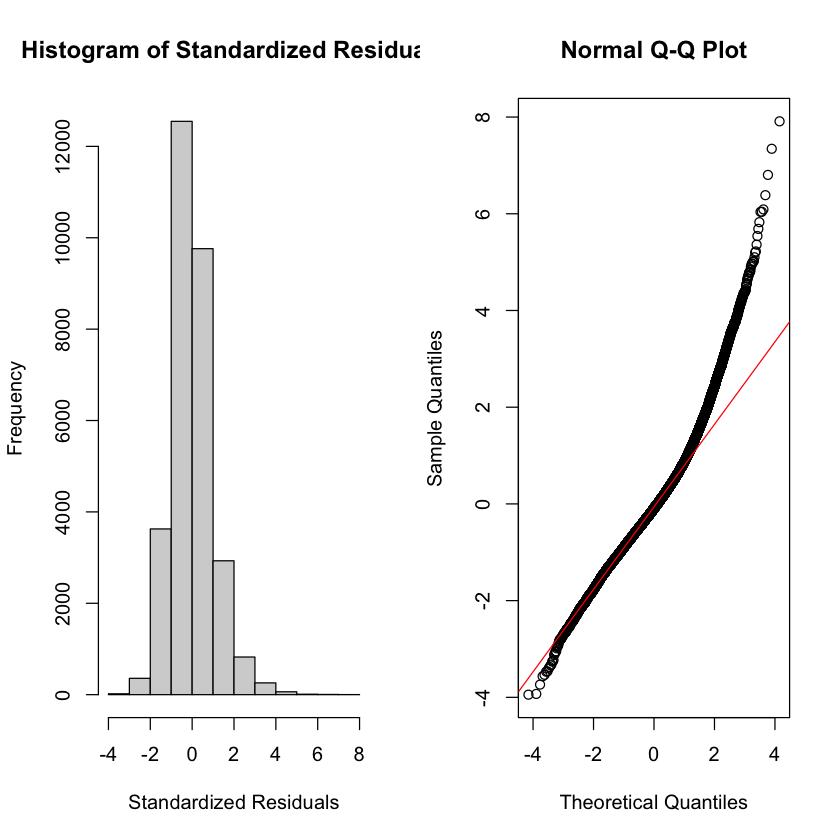

In [18]:
par(mfrow=c(1,2)) 
hist(rstandard(adj_model), xlab="Standardized Residuals", 
     main="Histogram of Standardized Residuals") 
qqnorm(rstandard(adj_model)) 
qqline(rstandard(adj_model),col="red")

### Homoscedasticity, Linearity, and Collinearity

We can also create a residual vs. fitted plot or plot the residuals against included covariates. Below, we plot the blood lead level against the residuals. In both plots, we are looking for the points to be spread roughly evenly around 0 with no discerning pattern. However, both plots shows a tunnel shape, indicating a growing and shrinking variance of residuals by level, respectively. This indicates that we are violating the homoscedasticity assumption.

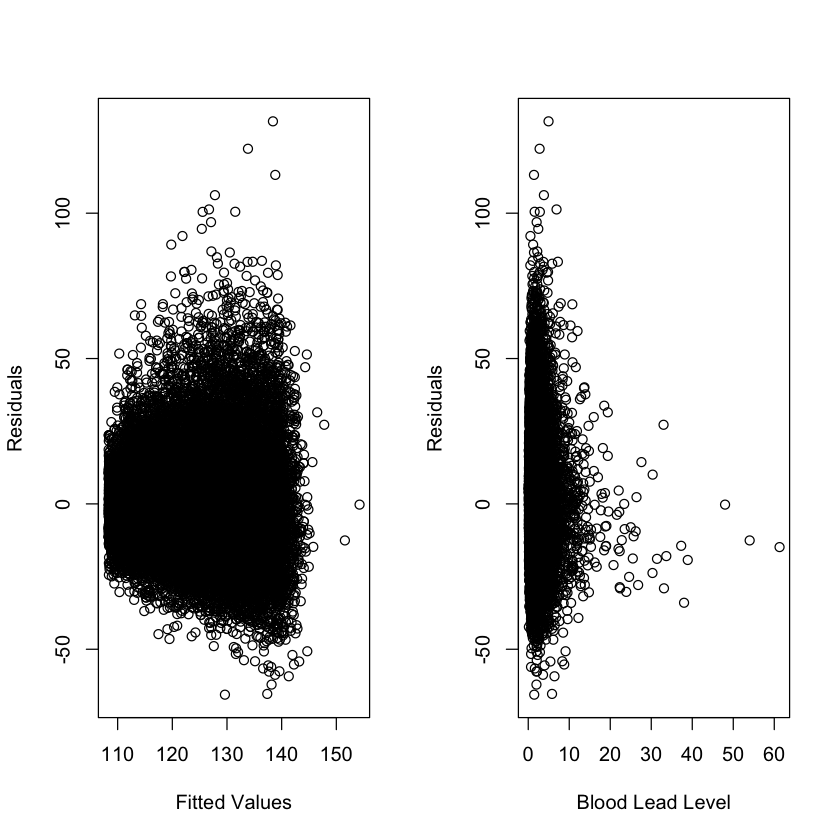

In [19]:
par(mfrow=c(1,2))
plot(fitted(adj_model), resid(adj_model), xlab="Fitted Values", ylab="Residuals")
plot(nhanes_df$LEAD, resid(adj_model), xlab="Blood Lead Level", ylab="Residuals")

To quantify any collinearity between the included covariates, we can calculate the variance inflation factors. The `vif()` function in the `car` package allows us to calculate the variance inflation factors or generalized variance inflation factors for all covariates. In our case, all the VIF values are around 1, indicating low levels of collinearity. 

In [20]:
vif(adj_model)

LEAD      AGE      SEX 
1.118042 1.069719 1.048606

### Practice Question

Fit a linear regression model with `SBP` as the outcome and with `INCOME`, `RACE`, `EDUCATION`, and `ALC` as independent variables. Then, plot the residuals vs. the fitted values as well and make a QQ plot for the standardized residuals from this model. They should look like this:

<img src="images/10-practicequestion2answer.png" alt= “” width="400pt" align="center">

In [21]:
# Insert your solution here: 

### Leverage and Influence

We may also be interested in how each observation is influencing the model. Leverage values measure how much an individual observation's $y$ value influences its own predicted value and indicate whether observations have extreme predictor values compared to the rest of the data. Leverage values range from 0 to 1 and sum to the number of estimated coefficients. Observations with high leverage have the potential to significantly impact the estimated regression coefficients and the overall fit of the model. Therefore, examining leverage values helps identify observations that may be influential or outliers. Below we find the ten highest leverage values and then find those observations in the data. 

In [22]:
sort(hatvalues(adj_model), decreasing=TRUE)[1:10]
nhanes_df[order(hatvalues(adj_model), decreasing=TRUE),] %>% 
  select(c(SBP, LEAD, AGE, SEX)) %>% head(10)

23016        2511        3091       21891        3661         511 
0.038986057 0.029359436 0.022698800 0.014841727 0.014432719 0.013993186 
      21892       15321        6511        3452 
0.011587215 0.010797767 0.010220042 0.009679122

,SBP,LEAD,AGE,SEX
,<dbl>,<dbl>,<dbl>,<fct>
23016,129,61.29,38,Male
2511,139,54.00,61,Male
3091,154,48.00,72,Male
21891,123,38.90,54,Male
3661,101,38.00,39,Male
511,118,37.30,34,Male
21892,107,33.67,21,Male
15321,104,33.10,39,Male
6511,175,33.00,71,Male


Some other measures of influence are the DFBETAs and Cook's distance, which measure how much each observation influences the estimated coefficients and the estimated `y` values, respectively. The `influence.measures()` function provides a set of measures that quantify the influence of each observation on a linear regression model: these include the DFBETAS for each model variable, DFFITS, covariance ratios, Cook's distances, and the leverage values. The output returns the values in a matrix called `infmat`, which we convert to a data frame below.

In [23]:
inf_mat <- influence.measures(adj_model)[['infmat']]
as.data.frame(inf_mat) %>% head()

,dfb.1_,dfb.LEAD,dfb.AGE,dfb.SEXF,dffit,cov.r,cook.d,hat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0138799518,-0.0175643062,-1.683345e-02,0.0083187286,-0.034265619,0.9995083,2.934831e-04,1.898938e-04
2,-0.0007323058,0.0003481166,-3.918891e-05,0.0010513411,-0.001495317,1.0001932,5.590112e-07,6.607023e-05
3,0.0221373044,0.0057489501,-1.454111e-02,-0.0168432662,0.029635103,0.9988200,2.194905e-04,8.280908e-05
4,0.0004990424,0.0010428901,-2.072439e-03,0.0016309535,-0.003115033,1.0002393,2.425931e-06,1.184573e-04
5,0.0022594480,-0.0027253450,-2.499295e-03,0.0009734915,-0.004978427,1.0003527,6.196367e-06,2.349179e-04
6,-0.0012828825,-0.0005585861,1.647487e-03,-0.0029288547,-0.004412697,1.0001808,4.868096e-06,8.089475e-05


## Interactions and Transformations

We now try to improve our model. To start, we look at potential transformations for our outcome variable. We will consider a log transformation for both our outcome, systolic blood pressure, and our predictor of interest, blood lead level. Both of these variables have a fairly skewed distribution and may benefit from such a transformation. Below, you can see that the transformed variables have distributions that are more symmetrical.

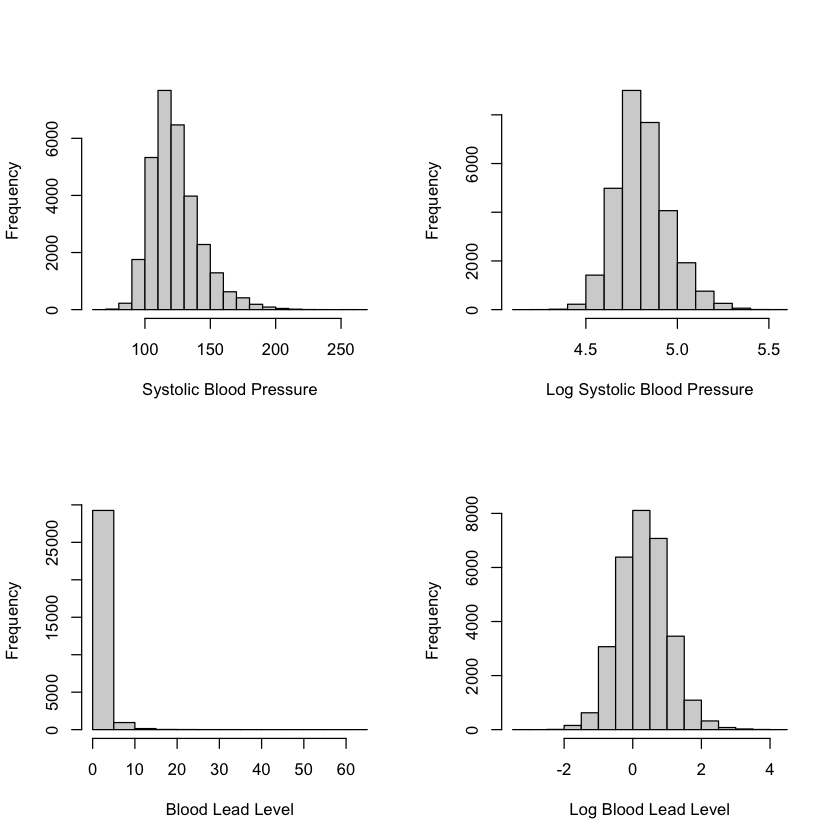

In [24]:
par(mfrow=c(2,2))
hist(nhanes_df$SBP, xlab="Systolic Blood Pressure", main="")
hist(log(nhanes_df$SBP), xlab="Log Systolic Blood Pressure", main="")
hist(nhanes_df$LEAD, xlab="Blood Lead Level", main="")
hist(log(nhanes_df$LEAD), xlab="Log Blood Lead Level", main="")

To add a transformation to a model, we can simply apply the transformation in the formula for `lm()`. We will calculate the adjusted R-squared for each potential model to compare their fits in addition to plotting the four qq-plots. Both indicate that the model with the log-log transformation (that is, with a log transformation applied to both the `SBP` and the `LEAD` variables) is the best fit though the model with just a log transformation for `SBP` has a similar qq-plot. 

In [25]:
model_nlog_nlog <- lm(SBP ~ LEAD + AGE + SEX, data = nhanes_df)
model_log_nlog <- lm(log(SBP) ~ LEAD + AGE + SEX, data = nhanes_df)
model_nlog_log <- lm(SBP ~ log(LEAD) + AGE + SEX, data = nhanes_df)
model_log_log <- lm(log(SBP) ~ log(LEAD) + AGE + SEX, data = nhanes_df)

In [26]:
summary(model_nlog_nlog)$adj.r.squared
summary(model_log_nlog)$adj.r.squared
summary(model_nlog_log)$adj.r.squared
summary(model_log_log)$adj.r.squared

[1] 0.2115378

[1] 0.2146037

[1] 0.211921

[1] 0.2150189

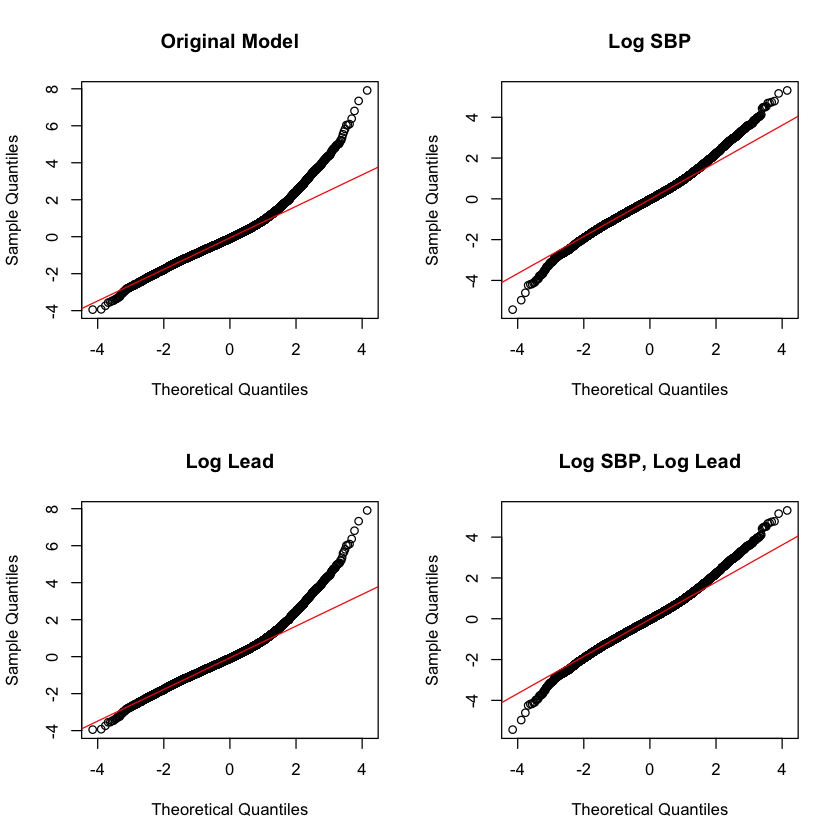

In [27]:
par(mfrow=c(2,2))
qqnorm(rstandard(model_nlog_nlog), main="Original Model") 
qqline(rstandard(model_nlog_nlog),col="red")
qqnorm(rstandard(model_log_nlog), main="Log SBP") 
qqline(rstandard(model_log_nlog),col="red")
qqnorm(rstandard(model_nlog_log), main="Log Lead") 
qqline(rstandard(model_nlog_log),col="red")
qqnorm(rstandard(model_log_log), main="Log SBP, Log Lead") 
qqline(rstandard(model_log_log),col="red")

### Practice Question

Instead of adding in a log transformation for `LEAD` like we did above, try a square root transformation `sqrt(LEAD)` and an inverse transformation `1/LEAD` while keeping the log transformation for the outcome `log(SBP)`. Which model fits better according to the adjusted R-squared? The resulting QQ plots should look like this: 

<img src="images/10-practicequestion3answer.png" alt= “” width="400pt" align="center">

In [28]:
# Insert your solution here:

Additionally, we might consider polynomial transformations. The `poly(x, degree=1)` function allows us to specify a polynomial transformation where we might have higher degree terms. We do not pursue this for this particular example, but we show some example code below for creating such a transformation (in this case, a cubic transformation for blood lead level).

In [29]:
model_poly <- lm(SBP ~ poly(LEAD, 3) + AGE + SEX, data = nhanes_df)

We can summarize the outcome for our log-log model using the `tidy()` function again. We observe small p-values for each estimated coefficient.

In [30]:
tidy(model_log_log)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),4.620621472,2.391943e-03,1931.743667,0.000000e+00
log(LEAD),0.008909484,1.183673e-03,7.526978,5.336443e-14
AGE,0.003494946,4.573668e-05,76.414522,0.000000e+00
SEXMale,0.025427995,1.547464e-03,16.432047,2.055983e-60


Another component that we may want to add to our model is an interaction term. For example, we may consider an interaction between sex and blood lead level. We add an interaction to the formula using a `:` between the two variables. The output below shows that the coefficient for this interaction is indeed significant.

In [31]:
model_interaction <- lm(log(SBP) ~ log(LEAD) + AGE + SEX + SEX:log(LEAD), 
                        data=nhanes_df) 
summary(model_interaction)


Call:
lm(formula = log(SBP) ~ log(LEAD) + AGE + SEX + SEX:log(LEAD), 
    data = nhanes_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69806 -0.08161 -0.00491  0.07524  0.65992 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        4.621e+00  2.387e-03 1936.15   <2e-16 ***
log(LEAD)          2.364e-02  1.681e-03   14.07   <2e-16 ***
AGE                3.448e-03  4.578e-05   75.30   <2e-16 ***
SEXMale            3.323e-02  1.668e-03   19.92   <2e-16 ***
log(LEAD):SEXMale -2.660e-02  2.159e-03  -12.32   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1279 on 30400 degrees of freedom
Multiple R-squared:  0.219,	Adjusted R-squared:  0.2189 
F-statistic:  2131 on 4 and 30400 DF,  p-value: < 2.2e-16


## Evaluation Metrics

Besides the adjusted R-squared, there are a few other metrics that can help us to understand how well our model fits the data and to help with model selection. The `AIC()` and `BIC()` functions find the Akaike information criterion (AIC) and Bayesian information criterion (BIC) values, respectively. Both AIC and BIC balance the trade-off between model complexity and goodness of fit. AIC takes into account both the goodness of fit (captured by the likelihood of the model) and the complexity of the model (captured by the number of parameters used). Lower AIC values are preferable. BIC is similar to AIC but has a stronger penalty for model complexity compared to AIC. Both measures indicate a preference for keeping the interaction term.

In [32]:
AIC(model_log_log)
AIC(model_interaction)

[1] -38610.47

[1] -38759.96

In [33]:
BIC(model_log_log)
BIC(model_interaction)

[1] -38568.86

[1] -38710.02

The `predict()` function allows us to calculate the predicted `y` values. When called on a model with no data specified, it returns the predicted values for the training data. We could also specify new data using the `newdata` argument. The new data provided must contain the columns given in the model formula. Below, we use the `predict()` function to find the predicted values from our model and then calculate the mean absolute error (MAE) and mean squared error (MSE) for our model. MAE is less sensitive to outliers compared to MSE. The mean absolute error indicates that our model has fairly high residuals on average. While this model may be helpful to understand the relationship between blood lead level and systolic blood pressure, it would not be very useful as a tool to predict the latter. 

In [34]:
pred_y <- predict(model_interaction)

In [35]:
mae <- mean(abs(nhanes_df$SBP - pred_y))
mae

[1] 118.9627

In [36]:
mse <- mean((nhanes_df$SBP- pred_y)^2)
mse

[1] 14501.92

## Stepwise Selection

So far we have ignored the other variables in the data frame. When performing variable selection, there are multiple methods to use. We will end this chapter by demonstrating how to implement one such method, **stepwise selection**, in R. The `step()` function takes in an initial model to perform stepwise selection on along with a direction `direction` ("forward", "backward", or "both"), and a scope `scope`. The scope specifies the lower and upper model formulas to consider. Below, we use forward selection so the lower formula is the formula for our current model and the upper formula contains the other covariates we are considering adding in. These two formulas must be nested - that is, all terms in the lower formula must be contained in the upper formula. 

By default, the `step()` function prints each step in the process and uses AIC to guide its decisions. We can set `trace=0` to avoid the print behavior and update the argument `k` to `log(n)` to use BIC, where `n` is the number of observations. Below we see that the algorithm first adds in race, then BMI, then income, then education, and then smoking status. In fact, all variables were added to the model! The final output is an `lm` object that we can use just like the ones earlier in this chapter. We get the summary of the final model and see that the adjusted R-squared has improved to 0.2479.

In [37]:
mod_step <- step(model_interaction, direction = 'forward', 
                 scope = list(lower = "log(SBP) ~ log(LEAD) + AGE + SEX:log(LEAD)", 
                              upper = "log(SBP) ~ log(LEAD) + AGE + SEX:log(LEAD) + 
                              SEX + RACE + EDUCATION + SMOKE + INCOME + BMI_CAT"))

Start:  AIC=-125047.6
log(SBP) ~ log(LEAD) + AGE + SEX + SEX:log(LEAD)

            Df Sum of Sq    RSS     AIC
+ RACE       4    9.1605 488.19 -125605
+ BMI_CAT    2    8.9722 488.38 -125597
+ INCOME     1    2.8709 494.48 -125222
+ EDUCATION  2    1.8966 495.46 -125160
+ SMOKE      2    0.3496 497.00 -125065
<none>                   497.35 -125048

Step:  AIC=-125604.9
log(SBP) ~ log(LEAD) + AGE + SEX + RACE + log(LEAD):SEX

            Df Sum of Sq    RSS     AIC
+ BMI_CAT    2    7.1612 481.03 -126050
+ INCOME     1    1.7985 486.39 -125715
+ EDUCATION  2    1.3404 486.85 -125684
+ SMOKE      2    0.1297 488.06 -125609
<none>                   488.19 -125605

Step:  AIC=-126050.2
log(SBP) ~ log(LEAD) + AGE + SEX + RACE + BMI_CAT + log(LEAD):SEX

            Df Sum of Sq    RSS     AIC
+ INCOME     1   1.61678 479.42 -126151
+ EDUCATION  2   1.11221 479.92 -126117
+ SMOKE      2   0.26139 480.77 -126063
<none>                   481.03 -126050

Step:  AIC=-126150.5
log(SBP) ~ log(LEA

In [38]:
summary(mod_step)


Call:
lm(formula = log(SBP) ~ log(LEAD) + AGE + SEX + RACE + BMI_CAT + 
    INCOME + EDUCATION + SMOKE + log(LEAD):SEX, data = nhanes_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.67127 -0.07992 -0.00393  0.07377  0.67974 

Coefficients:
                         Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             4.614e+00  3.316e-03 1391.511  < 2e-16 ***
log(LEAD)               2.282e-02  1.694e-03   13.473  < 2e-16 ***
AGE                     3.485e-03  4.848e-05   71.872  < 2e-16 ***
SEXMale                 3.466e-02  1.655e-03   20.945  < 2e-16 ***
RACEOther Hispanic     -7.106e-03  3.223e-03   -2.205   0.0275 *  
RACENon-Hispanic White -4.449e-03  2.198e-03   -2.024   0.0430 *  
RACENon-Hispanic Black  3.369e-02  2.466e-03   13.662  < 2e-16 ***
RACEOther Race          6.270e-03  3.388e-03    1.850   0.0643 .  
BMI_CAT25<BMI<30        1.513e-02  1.838e-03    8.230  < 2e-16 ***
BMI_CATBMI>=30          3.783e-02  1.835e-03   20.623  < 2e-16 ***
INCOM

## Recap Video


<div class="video-container">
    <iframe width="700" height="500" src="https://www.youtube.com/embed/l4efC80vElw" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>
</div>



## Exercises

For these exercises, we will continue using the `nhanes_df` data.

1. Construct a linear model using `DBP` as the output and `LEAD`, `AGE`, and `EVER_SMOKE` as features, and print the output.

In [39]:
model_exercise1 <- lm(DBP~LEAD + AGE + SMOKE, data = nhanes_df)
summary(model_exercise1)


Call:
lm(formula = DBP ~ LEAD + AGE + SMOKE, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-76.894  -7.293   0.561   7.883  60.902 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     71.815455   0.237372 302.544  < 2e-16 ***
LEAD             0.312515   0.044106   7.085 1.42e-12 ***
AGE             -0.034381   0.004683  -7.342 2.16e-13 ***
SMOKEQuitSmoke  -0.707128   0.188252  -3.756 0.000173 ***
SMOKEStillSmoke -0.329253   0.195901  -1.681 0.092829 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.36 on 30400 degrees of freedom
Multiple R-squared:  0.003634,	Adjusted R-squared:  0.003503 
F-statistic: 27.72 on 4 and 30400 DF,  p-value: < 2.2e-16


2. Use forward stepwise selection to add possible interactions to the linear model from the previous question.

In [40]:
model_int <- lm(DBP~ LEAD*AGE + LEAD*SMOKE + AGE*SMOKE, data = nhanes_df)
model_exercise2 <- step(model_exercise1, scope = list(lower = model_exercise1, upper = model_int), direction = "forward")
summary(model_exercise2)

Start:  AIC=157630.6
DBP ~ LEAD + AGE + SMOKE

             Df Sum of Sq     RSS    AIC
+ AGE:SMOKE   2     38998 5385292 157415
+ LEAD:AGE    1     18941 5405349 157526
+ LEAD:SMOKE  2      2882 5421408 157618
<none>                    5424290 157631

Step:  AIC=157415.2
DBP ~ LEAD + AGE + SMOKE + AGE:SMOKE

             Df Sum of Sq     RSS    AIC
+ LEAD:AGE    1   17291.8 5368000 157319
+ LEAD:SMOKE  2    2597.3 5382695 157405
<none>                    5385292 157415

Step:  AIC=157319.4
DBP ~ LEAD + AGE + SMOKE + AGE:SMOKE + LEAD:AGE

             Df Sum of Sq     RSS    AIC
+ LEAD:SMOKE  2    8368.8 5359632 157276
<none>                    5368000 157319

Step:  AIC=157276
DBP ~ LEAD + AGE + SMOKE + AGE:SMOKE + LEAD:AGE + LEAD:SMOKE




Call:
lm(formula = DBP ~ LEAD + AGE + SMOKE + AGE:SMOKE + LEAD:AGE + 
    LEAD:SMOKE, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-74.389  -7.154   0.507   7.877  59.426 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          68.574569   0.363204 188.804  < 2e-16 ***
LEAD                  1.552367   0.146653  10.585  < 2e-16 ***
AGE                   0.045604   0.007753   5.882 4.10e-09 ***
SMOKEQuitSmoke        5.213190   0.595584   8.753  < 2e-16 ***
SMOKEStillSmoke      -3.692704   0.577567  -6.394 1.64e-10 ***
AGE:SMOKEQuitSmoke   -0.133346   0.010859 -12.280  < 2e-16 ***
AGE:SMOKEStillSmoke   0.065437   0.012584   5.200 2.00e-07 ***
LEAD:AGE             -0.030357   0.002654 -11.437  < 2e-16 ***
LEAD:SMOKEQuitSmoke   0.797330   0.115738   6.889 5.72e-12 ***
LEAD:SMOKEStillSmoke  0.307386   0.103440   2.972  0.00296 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 

3. Draw a QQ plot for the model in Question 2, and describe the distribution that you observe.

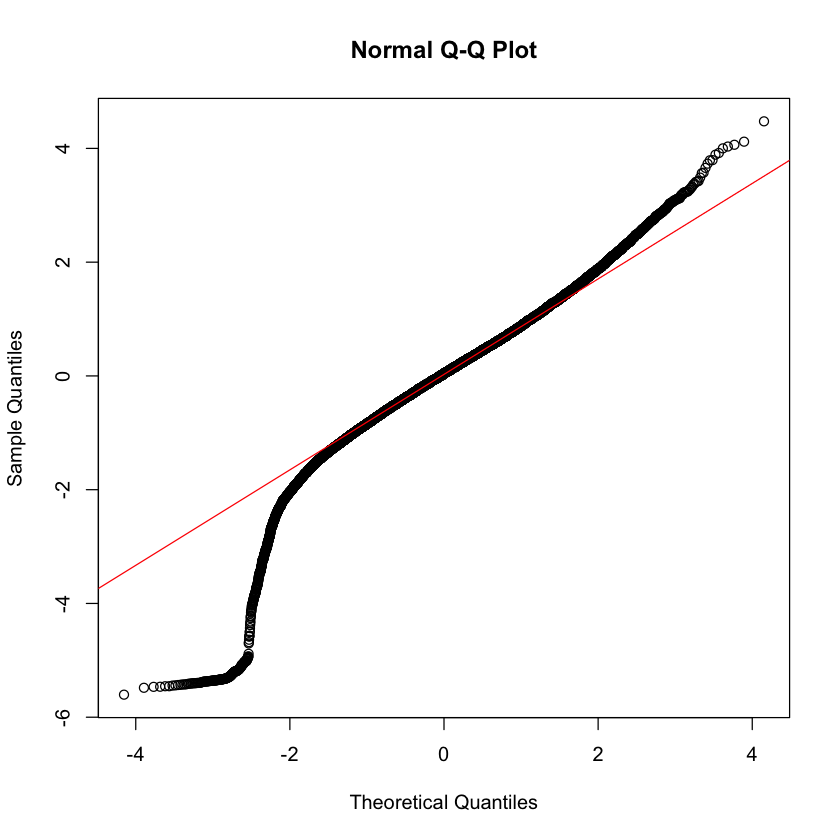

In [41]:
#solutions:
qqnorm(rstandard(model_exercise2)) 
qqline(rstandard(model_exercise2),col="red") 
#qq plot shows a fat-tail trend

4. Report the MAE and MSE of the model developed in Question 2. Then, find the row numbers of the observations with the top 5 Cook's Distance values for this model.

In [42]:
#first find the prediction by this model
predicted <- predict(model_exercise2)

#mae
mae <- mean(abs(nhanes_df$DBP - predicted))
cat('MAE: ', mae, '\n')

#mse
mse <- mean((nhanes_df$DBP- predicted)^2)
cat('MSE: ', mse, '\n')

#cooks distance
inf_mat <- influence.measures(model_exercise2)[['infmat']]
as.data.frame(inf_mat) %>% arrange(desc(cook.d)) %>% head()

MAE:  9.715737 


MSE:  176.2747 


,dfb.1_,dfb.LEAD,dfb.AGE,dfb.SMOKEQ,dfb.SMOKES,dfb.AGE:SMOKEQ,dfb.AGE:SMOKES,dfb.LEAD:A,dfb.LEAD:SMOKEQ,dfb.LEAD:SMOKES,dffit,cov.r,cook.d,hat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
23016,0.2640335,-0.81321257,0.009289248,0.005131562,0.003504752,-0.164028634,-0.182284678,0.3764125,0.4967113,0.6885572,-1.0608948,1.133891,0.11252298,0.12017868
21771,0.2342671,-0.39064903,-0.251391750,0.054821190,0.042760407,-0.007779010,0.117563624,0.4478615,-0.1400314,-0.4133489,-0.7321156,1.040380,0.05357971,0.04232476
21892,0.2543334,-0.64174304,-0.137683215,0.052413689,0.051816990,-0.098278536,-0.135686720,0.4701306,0.1465568,0.3298365,-0.6685233,1.064477,0.04468393,0.06233858
27328,-0.1184920,0.04527057,0.282658654,-0.085672504,-0.086646583,-0.052203542,-0.006329413,-0.3578025,0.4499684,0.3772355,-0.6550011,1.013075,0.04287370,0.01954587
15207,0.1710424,-0.28521946,-0.183545366,0.040025877,0.021956925,-0.005679587,0.084942301,0.3269913,-0.1022393,-0.2784658,-0.5102955,1.030810,0.02603427,0.03207522
3661,0.1131579,-0.37404953,0.015738301,0.003067133,0.002387665,-0.079515173,-0.086288968,0.1632868,0.2424361,0.3288641,-0.5014283,1.044462,0.02513934,0.04397503


5. Look at some diagnostic plots for the model and use what you observe from these plots to choose a transformation that will improve the fit of this model. Then, fit and summarize this new model with the transformation included. How do the MSE and MAE of the new model compare to the previous one? Note that your predictions will be on the transformed scale so you'll need to convert them to the correct scale. 


Call:
lm(formula = log(DBP + 1) ~ LEAD * AGE + LEAD * SMOKE + SMOKE * 
    AGE, data = nhanes_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3180 -0.0734  0.0412  0.1405  0.6559 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           4.243e+00  1.009e-02 420.669  < 2e-16 ***
LEAD                  3.040e-02  4.073e-03   7.465 8.54e-14 ***
AGE                   6.792e-05  2.153e-04   0.315 0.752437    
SMOKEQuitSmoke        9.514e-02  1.654e-02   5.752 8.91e-09 ***
SMOKEStillSmoke      -7.180e-02  1.604e-02  -4.476 7.62e-06 ***
LEAD:AGE             -6.650e-04  7.372e-05  -9.020  < 2e-16 ***
LEAD:SMOKEQuitSmoke   1.833e-02  3.214e-03   5.701 1.20e-08 ***
LEAD:SMOKEStillSmoke  6.733e-03  2.873e-03   2.344 0.019091 *  
AGE:SMOKEQuitSmoke   -2.477e-03  3.016e-04  -8.213 2.24e-16 ***
AGE:SMOKEStillSmoke   1.203e-03  3.495e-04   3.441 0.000579 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard er

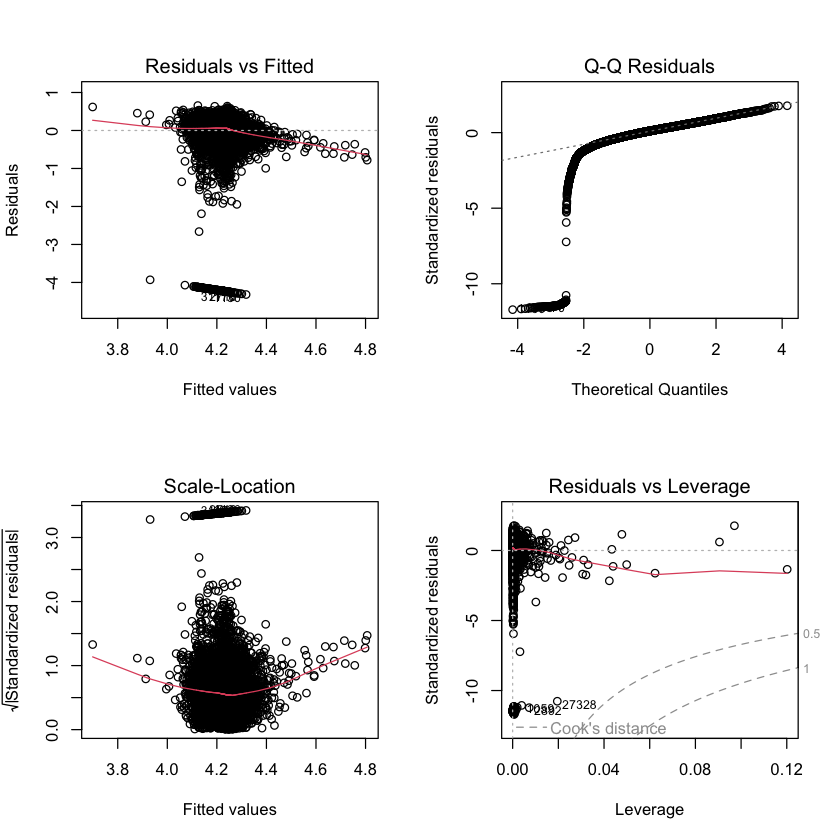

In [43]:
#use log(DBP1 + 1) beacuase DBP1 has 0, and r can't deal with log transformation with 0
#this transformation creates the most outliers, but it also makes the model more normally
#distributed and improves homoscedasticity
model_exercise5 <- lm(log(DBP+1) ~ LEAD*AGE + LEAD*SMOKE + SMOKE*AGE, data=nhanes_df) 
summary(model_exercise5)

par(mfrow=c(2,2))
plot(model_exercise5)